In [1]:
# Test Policy 5: vax 0x / wk, unvax 3x / wk
# Assumptions
# 1. Outside infection rate: 10 * student outside infection rate from last year
# 2. Initial prevalence same as UGs

In [2]:
import sys
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
module_path = os.path.abspath(os.path.join('../../..'))
if module_path + "/src/simulations_v2" not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
    
from load_params import load_params
from analysis_helpers import get_cumulative_infection_cols

from multi_group_simulation import MultiGroupSimulation
from vax_sim_utils import load_vax_group_configs, create_multigrp_vax_sim, process_vax_config

In [3]:
def load_vax_config(vac_perc, test_policy):
    # load vax config
    with open(os.getcwd() + "/../vax_sim_nominal_params/employee_vax_config.yaml", "rb") as f:
        employee_vax_config = yaml.load(f)
    
    # process vax config
    employee_vax_config['vax_proportion'] = vac_perc
    employee_vax_config['vax_test_freq'] = test_policy[0]
    employee_vax_config['unvax_test_freq'] = test_policy[1]
    employee_vax_config = process_vax_config(employee_vax_config)
    
    return employee_vax_config


def get_case_counts(sim, N=25, T=112):
    inf_count = list()
    cum_inf_cols = get_cumulative_infection_cols(sim.run_new_trajectory(T=1)[1])
    for _ in range(N):
        inf_count.append(np.array(sim.run_new_trajectory(T)[1][cum_inf_cols].sum(axis=1))[-1])
    return np.quantile(inf_count, 0.5)


def get_contour_inf(contact_rate_mult, vac_perc, test_policy):
    employee_vax_config = load_vax_config(vac_perc, test_policy)
    # Adjustment for contact_rate_mult
    contact_matrix = employee_vax_config[2]
    contact_matrix *= contact_rate_mult
    for i, param in enumerate(employee_vax_config[0]):
        param['expected_contacts_per_day'] = contact_matrix[i,i]
    sim = create_multigrp_vax_sim(employee_vax_config[0], employee_vax_config[1], contact_matrix, 0.5, 0.21)
    median_inf = get_case_counts(sim)
    return median_inf

In [4]:
contacts_per_day_mults = np.linspace(1,3,7)
vax_percs = np.linspace(0.7,1,7)

test_policy = [0/7, 3/7]

Zs_inf = []

for contact_mult in contacts_per_day_mults:
    Z_inf = []
    for vax_perc in vax_percs:
        Z_inf.append(get_contour_inf(contact_mult, vax_perc, test_policy))
    Zs_inf.append(Z_inf)

/home/aaj54/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


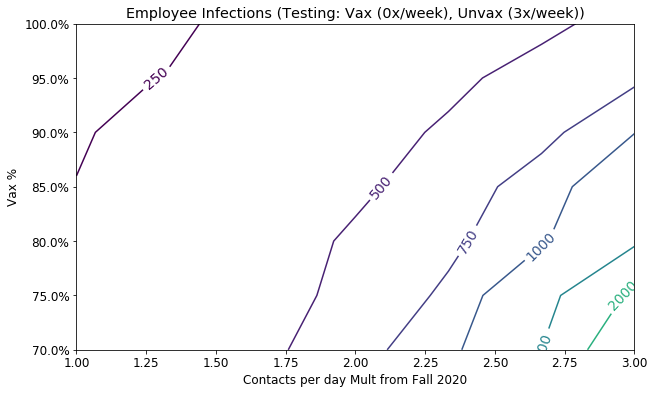

In [6]:
plt.figure(figsize=(10,6))
plt.title("Employee Infections (Testing: Vax (0x/week), Unvax (3x/week))")
plt.ylabel("Vax %")
plt.xlabel("Contacts per day Mult from Fall 2020")
CS = plt.contour(np.array(contacts_per_day_mults), 100*np.array(vax_percs), np.array(Zs_inf).T, levels=[250, 500, 750, 1000, 1500, 2000, 3000])
# CS = plt.contour(np.array(contacts_per_day_mults), 100*np.array(vax_percs), np.array(Zs_inf).T, locator=ticker.LogLocator())
plt.clabel(CS, inline=1, fmt='%d', fontsize=14)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()